<a href="https://colab.research.google.com/github/damiles/democolab/blob/master/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Download dataset
!git clone -l -s https://github.com/srohit0/food_mnist.git food_mnist

fatal: destination path 'food_mnist' already exists and is not an empty directory.


In [0]:
!ls food_mnist/

_config.yml	     images		     license_agreement.txt  README.md
createNewDataset.py  __init__.py	     meta
examples	     Keras_food_MNIST.ipynb  __pycache__


In [0]:
# import data
import food_mnist
(x_train, y_train), (x_test, y_test) = food_mnist.load_data()
labels_dict = food_mnist.labels()

In [0]:
print("Lables")
print(labels_dict)
print("train shape")
print(x_train.shape)
print("test shape")
print(x_test.shape)

Lables
{0: 'apple_pie', 1: 'baby_back_ribs', 2: 'baklava', 3: 'beef_carpaccio', 4: 'beef_tartare', 5: 'beet_salad', 6: 'beignets', 7: 'bibimbap', 8: 'bread_pudding', 9: 'breakfast_burrito'}
train shape
(3750, 224, 224, 3)
test shape
(1250, 224, 224, 3)


In [0]:
# Start to create our Neural Network with pytorch
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from torchvision import datasets, models, transforms
import time
import os
import copy

torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
data_transform = transforms.Compose([transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
x_train_tr = [data_transform(x) for i, x in enumerate(x_train)]
x_test_tr = [data_transform(x) for i, x in enumerate(x_test)]
# x_list = []
# for i, x in enumerate(x_train):
#   x_list.append(data_transform(x))
  
print(len(x_train_tr))
#print(x_train_transformed.shape)
#print(x_train_transformed[0][0])

3750


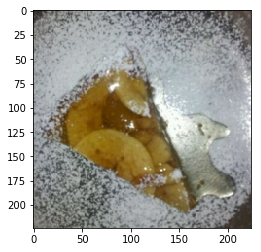

In [0]:
import matplotlib.pyplot as plt
import cv2
plt.imshow(cv2.cvtColor(x_train[0], cv2.COLOR_BGR2RGB))

In [0]:
# Create dataloaders for train and test in pytorch 
train = torch.utils.data.TensorDataset(torch.stack(x_train_tr), torch.as_tensor(y_train))
train_loader = torch.utils.data.DataLoader(train, 64, shuffle=True)
test = torch.utils.data.TensorDataset(torch.stack(x_test_tr), torch.as_tensor(y_test))
test_loader = torch.utils.data.DataLoader(test, 64, shuffle=True)

dataloaders = {"train": train_loader, "val": test_loader}
dataset_sizes = { "train": len(x_train_tr), "val": len(x_test_tr)}


In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
# Load a pretrained model
model_ft = models.resnet18(pretrained=True)
# Get the number of features of las layer before full connected layer
num_ftrs = model_ft.fc.in_features

# create the new last full connected layer shape
model_ft.fc = nn.Linear(num_ftrs, 10)

# upload model to device
model_ft = model_ft.to(device)

# create criterion 
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.8911 Acc: 0.3672
val Loss: 1.3024 Acc: 0.6296

Epoch 1/24
----------
train Loss: 1.0828 Acc: 0.6848
val Loss: 0.8680 Acc: 0.7296

Epoch 2/24
----------
train Loss: 0.7467 Acc: 0.7805
val Loss: 0.7164 Acc: 0.7792

Epoch 3/24
----------
train Loss: 0.5598 Acc: 0.8419
val Loss: 0.6226 Acc: 0.7792

Epoch 4/24
----------
train Loss: 0.4316 Acc: 0.8840
val Loss: 0.5765 Acc: 0.8032

Epoch 5/24
----------
train Loss: 0.3258 Acc: 0.9240
val Loss: 0.5452 Acc: 0.8064

Epoch 6/24
----------
train Loss: 0.2468 Acc: 0.9531
val Loss: 0.5335 Acc: 0.8136

Epoch 7/24
----------
train Loss: 0.1830 Acc: 0.9728
val Loss: 0.5268 Acc: 0.8136

Epoch 8/24
----------
train Loss: 0.1773 Acc: 0.9781
val Loss: 0.5221 Acc: 0.8136

Epoch 9/24
----------
train Loss: 0.1788 Acc: 0.9808
val Loss: 0.5208 Acc: 0.8168

Epoch 10/24
----------
train Loss: 0.1724 Acc: 0.9787
val Loss: 0.5255 Acc: 0.8208

Epoch 11/24
----------
train Loss: 0.1683 Acc: 0.9816
val Loss: 0.5190 Acc: 0.8168

Ep

In [0]:
# save full model
torch.save(model_ft, "model.tch")

In [0]:
!ls

food_mnist  model.tch  sample_data  torch_model


In [0]:
# export model to onnx
import torch.onnx

model_ft.eval()
x_input = torch.randn(1, 3, 224, 224, requires_grad=True)
torch_out = model_ft(x_input.to(device))

torch.onnx.export(model_ft, 
                  x_input.to(device), 
                  "model.onnx", 
                  export_params=True, 
                  opset_version=10, 
                  do_constant_folding=True, 
                  input_names=["input"], 
                  output_names=["output"])


In [0]:
!pip3 install onnx

     |████████████████████████████████| 7.1MB 2.7MB/s 


In [0]:
# check if model is correctly exported

import onnx

onnx_model = onnx.load("model.onnx")
onnx.checker.check_model(onnx_model)
onnx.helper.printable_graph(onnx_model.graph)

'graph torch-jit-export (\n  %input[FLOAT, 1x3x224x224]\n) initializers (\n  %conv1.weight[FLOAT, 64x3x7x7]\n  %bn1.weight[FLOAT, 64]\n  %bn1.bias[FLOAT, 64]\n  %bn1.running_mean[FLOAT, 64]\n  %bn1.running_var[FLOAT, 64]\n  %bn1.num_batches_tracked[INT64, scalar]\n  %layer1.0.conv1.weight[FLOAT, 64x64x3x3]\n  %layer1.0.bn1.weight[FLOAT, 64]\n  %layer1.0.bn1.bias[FLOAT, 64]\n  %layer1.0.bn1.running_mean[FLOAT, 64]\n  %layer1.0.bn1.running_var[FLOAT, 64]\n  %layer1.0.bn1.num_batches_tracked[INT64, scalar]\n  %layer1.0.conv2.weight[FLOAT, 64x64x3x3]\n  %layer1.0.bn2.weight[FLOAT, 64]\n  %layer1.0.bn2.bias[FLOAT, 64]\n  %layer1.0.bn2.running_mean[FLOAT, 64]\n  %layer1.0.bn2.running_var[FLOAT, 64]\n  %layer1.0.bn2.num_batches_tracked[INT64, scalar]\n  %layer1.1.conv1.weight[FLOAT, 64x64x3x3]\n  %layer1.1.bn1.weight[FLOAT, 64]\n  %layer1.1.bn1.bias[FLOAT, 64]\n  %layer1.1.bn1.running_mean[FLOAT, 64]\n  %layer1.1.bn1.running_var[FLOAT, 64]\n  %layer1.1.bn1.num_batches_tracked[INT64, scalar]\n

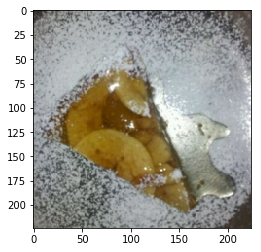

In [0]:
plt.imshow(cv2.cvtColor(x_train[0], cv2.COLOR_BGR2RGB))

In [0]:
!pip3 install onnxruntime

     |████████████████████████████████| 3.2MB 2.7MB/s 


In [0]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()
#print(to_numpy(test_input))

In [0]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("model.onnx")

print(ort_session.get_inputs()[0])
print(to_numpy(torch.stack([test_input])).shape)


NodeArg(name='input', type='tensor(float)', shape=[1, 3, 224, 224])
(1, 3, 224, 224)


882
Label
bibimbap
Prediction
bibimbap


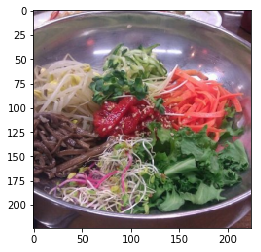

In [0]:
from random import randint
index = randint(0, len(x_test))
print(index)
print("Label")
print(labels_dict[y_test[index]])
test_input = data_transform(cv2.resize(x_test[index], (224,224)))
plt.imshow(cv2.cvtColor(x_test[index], cv2.COLOR_BGR2RGB))

ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(torch.stack([test_input]))}
ort_outs = ort_session.run(None, ort_inputs)
print("Prediction")
print(labels_dict[np.argmax(ort_outs)])

In [0]:
import socket
print(socket.gethostbyname(socket.getfqdn(socket.gethostname())))

172.28.0.2
